In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from functools import partial
from scipy.stats import f, ncf
from sklearn.metrics import r2_score
from tqdm.notebook import trange
from utils import *
from estimators import ClusteredSegmentation

In this example, there are ten binary variables (X_0 ... X_9) and the sample size is 15,000.  
When we use the cluster method with 40 groups/segments, tau estimate is .0247 and its lower bound is near 0

In [2]:
p, n = 10, 15_000
rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
y = rg()['y'].to_numpy().reshape(-1,1)
cluster = ClusteredSegmentation(n_clusters = 40)
cluster.fit(X, y)
tau = cluster.tau_metric
tau, tau.tau_est, tau.tau_LB

(tau(n=15000, p=1024, q=40, r_sqf=0.9806885897974638, r_sqr=0.9795112458166321, alpha=0.05),
 0.0609662354268186,
 1.1779091429207284e-16)

The intercept parameter of the linear model, the random sample generator based on, is 4.737, and the standard deviation of the error term is 6.2 and it follows a normal distribution.

In [3]:
rg.config.coefficient_generator_config

{'distribution': 'Gauss',
 'mean': 3.666322324459763,
 'error': 3.787637434409163}

The estimate of the variance of the errors is quite similar to the true value

In [4]:
cluster.MSE, rg.config.sigma**2

(18.29805500448615, 18.779539510921275)

We have 38 missing or unseen pairs.   
The unseen pairs are particular set of $x_i = (x_{i0}, ..., x_{i9})$ we have no observation on in our dataset/sample

In [5]:
from BarcodeScanner import barcodeScanner

scanner = barcodeScanner(estimator = cluster, config = rg.config)
scanner.raw_contrast, scanner.missingPairsMLE()

(<881x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 60510 stored elements in COOrdinate format>,
 <103x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 103 stored elements in Compressed Sparse Column format>)

First, we get the weighted mean of each segment/group

In [6]:
scanner.weighted_segment_means

0     [1.0, 1.0, 0.0, 0.42857142857142855, 1.0, 0.57...
1     [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
2     [0.9565217391304348, 1.0, 0.7391304347826086, ...
3     [1.0, 0.9444444444444444, 0.9444444444444444, ...
4     [0.851063829787234, 0.9574468085106383, 0.6170...
5     [0.7796610169491526, 0.8813559322033898, 0.279...
6     [0.9664804469273743, 0.8435754189944135, 0.821...
7     [0.861271676300578, 0.6069364161849711, 0.5086...
8     [0.885, 0.64, 0.5125, 0.2875, 0.38, 0.82, 0.82...
9     [0.6718346253229974, 0.6408268733850129, 0.498...
10    [0.9425675675675675, 0.5540540540540541, 0.253...
11    [0.7944785276073619, 0.4938650306748466, 0.677...
12    [0.7788697788697788, 0.6707616707616708, 0.599...
13    [0.816923076923077, 0.6015384615384616, 0.6430...
14    [0.6741424802110818, 0.7216358839050132, 0.532...
15    [0.6035911602209945, 0.7776243093922652, 0.566...
16    [0.7242744063324539, 0.8654353562005277, 0.770...
17    [0.7276908923643054, 0.796688132474701, 0.

Below is the first 5 examples of the missing pairs

In [7]:
scanner.missing_arrays[:5]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int8),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int8)]

We double check the size of unique pairs in the sample and the missing pairs. When you sum the two, it should be $2^10 = 1024$$

In [8]:
cluster.full_to_reduced.shape

(921, 1)

In [9]:
len(scanner.missing_arrays)

103

# Assigning missing pairs to segments

When fitting the cluster method, unseen/missing pairs are not assigned to any of the segments/groupgs.   
In this section, I would like to discuss three methods to assign missing pairs to segments.   
The **first** method is to get the euclidean distance between weighted mean of each segment and a missing pair.   
Then, we assign the missing pair to the segment where the euclidean distance is the lowest.

The **second** method is to use the mahalanobis distance between each segment and a missing pair.   
When finding the distance, we should choose between the pooled covariance and a covariance for each segment.   

The **third** method is to use the jesenshannon distance, which relies on the KL divergence.   
(discuss later)

### Euclidean Distance

In [10]:
scanner.assign_missing_euclidean.sort_values('full')

,full,reduced
0,0,14
1,1,11
2,2,10
3,3,11
4,4,10
...,...,...
1019,1019,32
1020,1020,33
1021,1021,33
1022,1022,32


### Mahalanobis Distance

In [11]:
from sklearn.covariance import EmpiricalCovariance

#### Case 1: Mahalanobis distance with covariance of each segment

In [12]:
table = scanner.segmentation_table.copy()
table['barcode'] = table.apply(lambda x: scanner.num_to_barcode(x['full'], 10).toarray()[0], axis = 1)

In [13]:
table

,full,reduced,counts,barcode
0,4,10,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,8,9,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,12,10,1,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
3,15,13,1,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]"
4,16,8,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...,...
916,1019,32,60,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1]"
917,1020,33,154,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]"
918,1021,33,56,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1]"
919,1022,32,81,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"


In [14]:
reduced = np.sort(table.reduced.unique())
covs = []
for r in reduced:
    barcodes = []
    r_table = table.loc[table.reduced.eq(r), ['barcode','counts']]
    for b, c in zip(r_table.barcode, r_table['counts']):
        barcodes += [b for _ in range(c)]
    barcodes = np.concatenate(barcodes).reshape(-1, 10)
    cov = EmpiricalCovariance()
    cov.fit(barcodes)
    covs.append(cov)

#### What we need : covs and table with the variable `barcode`

In [15]:
scanner.assign_missing_mahalanobis(pooled = False)

,full,reduced
0,0,0
1,1,0
2,2,0
3,3,0
4,4,10
...,...,...
1019,1019,32
1020,1020,33
1021,1021,33
1022,1022,32


[]

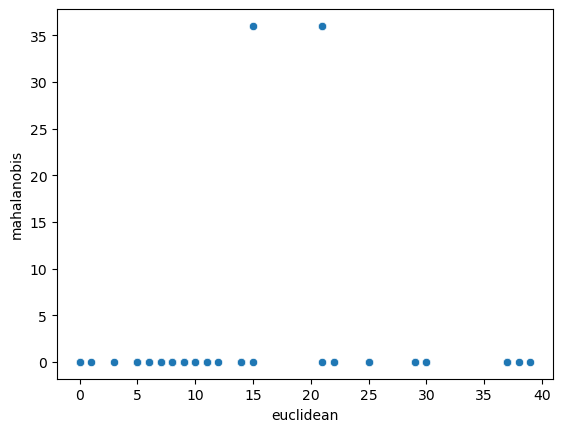

In [16]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_mahalanobis(pooled = False).loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','mahalanobis'])
sns.scatterplot(data = df, x = 'euclidean', y = 'mahalanobis', ax = ax)
plt.plot()

#### Case 1-a : Using robust covariance estimate (MCD)

[]

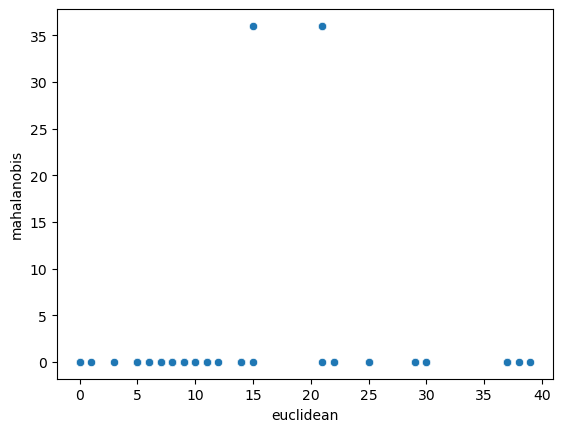

In [17]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_mahalanobis(pooled = False, robust = True).loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','mahalanobis'])
sns.scatterplot(data = df, x = 'euclidean', y = 'mahalanobis', ax = ax)
plt.plot()

#### Case 2: Mahalanobis distance with pooled covariance

In [18]:
scanner.missing_pairs_decimal_repr[0]

0

In [19]:
scanner.assign_missing_mahalanobis(pooled = True).loc[7,:].reduced, scanner.assign_missing_euclidean.loc[7,:].reduced

(11, 11)

In [20]:
scanner.assign_missing_mahalanobis(pooled = True)

,full,reduced
0,0,14
1,1,11
2,2,10
3,3,11
4,4,10
...,...,...
1019,1019,32
1020,1020,33
1021,1021,33
1022,1022,32


[]

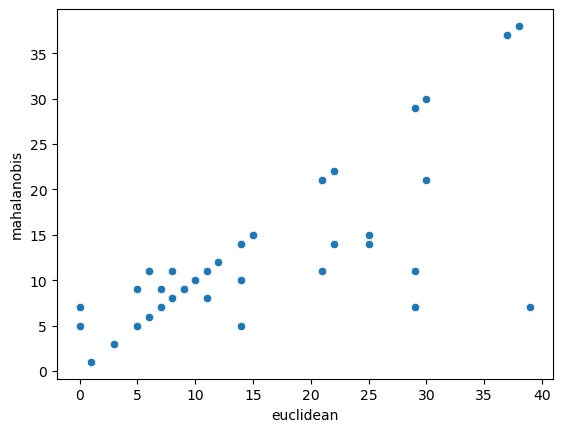

In [21]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_mahalanobis(pooled = True).loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','mahalanobis'])
sns.scatterplot(data = df, x = 'euclidean', y = 'mahalanobis', ax = ax)
plt.plot()

#### Case 2-a : Using robust covariance estimator

[]

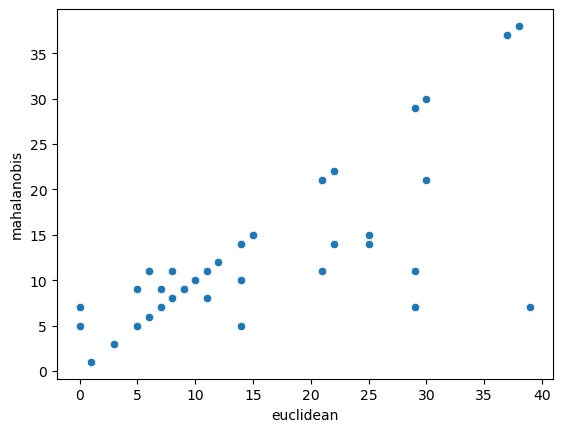

In [22]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_mahalanobis(pooled = True, robust = True).loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','mahalanobis'])
sns.scatterplot(data = df, x = 'euclidean', y = 'mahalanobis', ax = ax)
plt.plot()

## Jensen-Shannon  distance

#### Discussion 1: Assumption in independence between X's

To have a discussion on this topic, let's begin with an example. The below table shows the barcode in decimal numbers for the segment of its id 1.    

In [23]:
scanner.assign_missing_jensenshannon()

,full,reduced
0,0,30
1,1,30
2,2,30
3,3,30
4,4,10
...,...,...
1019,1019,32
1020,1020,33
1021,1021,33
1022,1022,32


[]

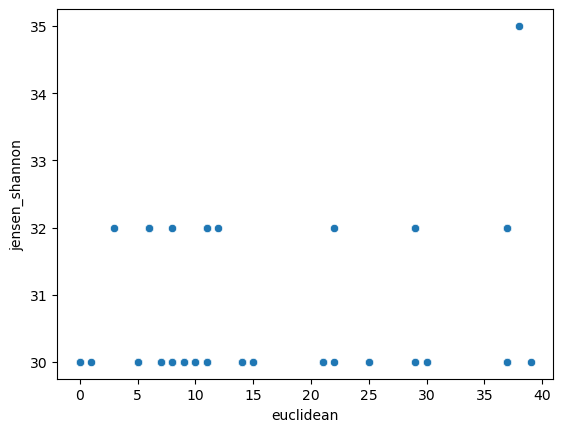

In [25]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_euclidean.loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_jensenshannon().loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['euclidean','jensen_shannon'])
sns.scatterplot(data = df, x = 'euclidean', y = 'jensen_shannon', ax = ax)
plt.plot()

[]

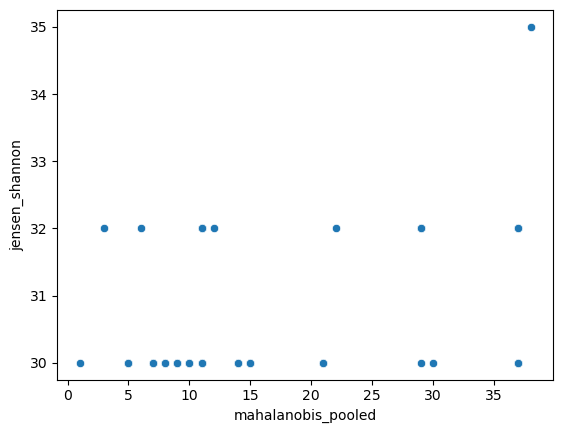

In [26]:
fig, ax = plt.subplots(1, 1)
euclidean_assignment = scanner.assign_missing_mahalanobis(pooled = True).loc[scanner.missing_pairs_decimal_repr,:].reduced
mahalanobis_assignment = scanner.assign_missing_jensenshannon().loc[scanner.missing_pairs_decimal_repr,:].reduced
df = pd.DataFrame(zip(euclidean_assignment, mahalanobis_assignment), columns = ['mahalanobis_pooled','jensen_shannon'])
sns.scatterplot(data = df, x = 'mahalanobis_pooled', y = 'jensen_shannon', ax = ax)
plt.plot()

#### Question: Should I just consider one-way KL-divergence"????

#### How I computed jensen-shannon

In [29]:
segment_1 = scanner.segmentation_table.loc[scanner.segmentation_table.reduced.eq(1),:]
segment_1['barcode'] = segment_1.full.apply(lambda x: scanner.num_to_barcode(x, 10).toarray().reshape(-1).tolist())

/var/folders/xj/07knx1_11gl5w1nv4tg4xr000000gn/T/ipykernel_2494/2479123770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_1['barcode'] = segment_1.full.apply(lambda x: scanner.num_to_barcode(x, 10).toarray().reshape(-1).tolist())


In [30]:
segment_1

,full,reduced,counts,barcode
430,478,1,6,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 0]"
462,510,1,10,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
813,862,1,16,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0]"
845,894,1,17,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 0]"


Suppose each X's are independent, then the probability of each sequence starting from \[0, \cdots, 0\] to \[1, \cdots, 1\] can be found using each element of the sequence of the weighted mean below.   
For example, the probability of having \[1,0,1,1,1,1,1,1,1,1\] would be 0 because the probability of the second element being 0 is 0. 

In [31]:
scanner.weighted_segment_means[1]

array([0.67346939, 1.        , 0.32653061, 1.        , 0.55102041,
       1.        , 1.        , 1.        , 1.        , 0.        ])

On the other hand, if each X's are dependent, we may find a probability of a particular sequence by using conditional probability. Then we may have that

$$ P(X = [1,0, \cdots, 0 ]) = P(X_9 = 0 | X_0 = 1, X_1 = 0, \cdots, X_8 = 0) \cdots P(X_1 = 0 | X_0 = 1) \cdot P(X_0 = 1)$$

In other words, the probability of a sequence is always 0 if they are not included in the given segment; if they are in the segment, their probability would be proportional to their counts. For example, the pmf of the segment above would be as below:

$P(X = [0,1,1,1,0,1,1,1,1,0]) = 6/49)$<br>
$P(X = [0,1,1,1,1,1,1,1,1,0]) = 10/49)$<br>
$P(X = [1,1,0,1,0,1,1,1,1,0]) = 16/49)$<br>
$P(X = [1,1,0,1,1,1,1,1,1,0]) = 17/49)$<br>

We will consider both conditions in the following demonstration.

#### Under independence assumption

In [118]:
weighted_mean = scanner.weighted_segment_means[2]

In [119]:
k = 500
prob = 0
while prob == 0:
    k += 1
    example_array = scanner.num_to_barcode(k, 10).toarray().reshape(-1)
    prob = np.prod([1-w if e == 0 else w  for e, w in zip(example_array, weighted_mean)])

In [120]:
k

502

In [121]:
example_array = scanner.num_to_barcode(510, 10).toarray().reshape(-1)

In [122]:
example_array 

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int8)

In [123]:
weighted_mean

array([0.47368421, 1.        , 0.40350877, 1.        , 0.42105263,
       1.        , 0.59649123, 1.        , 0.10526316, 0.        ])

In [124]:
prob_example = np.prod([1-w if e == 0 else w  for e, w in zip(example_array, weighted_mean)])

In [125]:
prob_example

0.00561456638939809

In [126]:
all_arrays = [scanner.num_to_barcode(x, 10).toarray().reshape(-1) for x in range(2**10)]

In [136]:
def check_ones(seq_a, seq_b):
    return np.all(np.isin(np.where(seq_a ==1)[0], np.where(seq_b ==1)[0]))

def check_zeros(seq_a, seq_b):
    return np.all(np.isin(np.where(seq_a ==0)[0], np.where(seq_b ==0)[0]))

def check_both(seq_a, seq_b):
    return check_ones(seq_a, seq_b)*check_zeros(seq_a, seq_b)

def find_prob(missing_array, weighted_mean):
    return np.prod([1-w if e == 0 else w  for e, w in zip(missing_array, weighted_mean)])

In [128]:
from functools import partial

In [129]:
cond = partial(check_both, weighted_mean)

prob = partial(find_prob, weighted_mean = weighted_mean)

In [130]:
prob_seq = [prob(x) for x in all_arrays if cond(x)]

In [131]:
missing = scanner.missing_arrays[0]

In [132]:
missing.tolist() in [x.tolist() for x in all_arrays if cond(x)]

False

In [133]:
prob_seq.append(0); prob_domain = [x.tolist() for x in all_arrays if cond(x)] if missing.tolist() in [x.tolist() for x in all_arrays if cond(x)] else  [x.tolist() for x in all_arrays if cond(x)] + [missing.tolist()]

In [134]:
missing_prob_seq = [0 for _ in range(len(prob_seq)-1)] + [1]

In [135]:
from scipy.spatial.distance import jensenshannon

jensenshannon(prob_seq, missing_prob_seq)

0.8325546111576977

In [146]:
missing = scanner.missing_arrays[0]

In [147]:
distance = []
all_arrays = [scanner.num_to_barcode(x, 10).toarray().reshape(-1) for x in range(2**10)]
for weighted_means in scanner.weighted_segment_means:
    cond = partial(check_both, weighted_means)
    prob = partial(find_prob, weighted_mean = weighted_means)
    prob_seq = [prob(x) for x in all_arrays if cond(x)]
    prob_domain = [x.tolist() for x in all_arrays if cond(x)] if missing.tolist() in [x.tolist() for x in all_arrays if cond(x)] else  [x.tolist() for x in all_arrays if cond(x)] + [missing.tolist()]
    if len(prob_seq) < len(prob_domain):
        prob_seq.append(0)
    missing_prob_seq = [0 for _ in range(len(prob_seq)-1)] + [1]
    d = jensenshannon(prob_seq, missing_prob_seq)
    distance.append(d)
    

In [148]:
distance.index(min(distance))

34

In [158]:
scanner.barcode_length

10

In [159]:
def find_reduced_jensenshannon(missing, all_arrays = None):
    distance = []
    if all_arrays:
        pass
    else:
        all_arrays = [scanner.num_to_barcode(x, scanner.barcode_length).toarray().reshape(-1) for x in range(2**scanner.barcode_length)]
    for weighted_means in scanner.weighted_segment_means:
        cond = partial(check_both, weighted_means)
        prob = partial(find_prob, weighted_mean = weighted_means)
        prob_seq = [prob(x) for x in all_arrays if cond(x)]
        prob_domain = [x.tolist() for x in all_arrays if cond(x)] if missing.tolist() in [x.tolist() for x in all_arrays if cond(x)] else  [x.tolist() for x in all_arrays if cond(x)] + [missing.tolist()]
        if len(prob_seq) < len(prob_domain):
            prob_seq.append(0)
        missing_prob_seq = [0 for _ in range(len(prob_seq)-1)] + [1]
        d = jensenshannon(prob_seq, missing_prob_seq)
        distance.append(d)
    return distance.index(min(distance))


In [160]:
find_reduced_jensenshannon(missing)

34

In [180]:
#joblib example
from time import sleep
from joblib import Parallel, delayed
from tqdm.notebook import trange
r = Parallel(n_jobs = -1, verbose=0)(delayed(sleep)(2) for _ in range(10)) 

In [182]:
reduced = Parallel(n_jobs = -1, verbose = 10)(delayed(find_reduced_jensenshannon)(missing, all_arrays) for missing in scanner.missing_arrays)
full = scanner.missing_pairs_decimal_repr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  35 out of  49 | elapsed:   40.8s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  40 out of  49 | elapsed:   41.4s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  45 out of  49 | elapsed:   49.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:   49.8s finished


In [183]:
fill_missing_df = pd.DataFrame(zip(full, reduced), columns = ['full','reduced'])

In [186]:
original_table = scanner.segmentation_table.drop('counts',axis = 1)

In [188]:
pd.concat([original_table, fill_missing_df], ignore_index = True).sort_values('full').reset_index(drop = True)

,full,reduced
0,0,16
1,1,28
2,2,21
3,3,29
4,4,21
...,...,...
1019,1019,26
1020,1020,5
1021,1021,29
1022,1022,0
